In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

In [66]:
df = pd.read_csv('/Users/azulmakk/Universidad/Datasets/Predictiva/dataset.csv')

In [67]:
print(df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


In [68]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['track_id'], axis=1)

In [69]:
scaler = StandardScaler()
numeric_features = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [70]:
import pandas as pd

def agregar_estadisticas_por_grupo(df, columna, columna_grupo):

    max_columna_por_grupo = df.groupby(columna_grupo)[columna].transform('max')
    min_columna_por_grupo = df.groupby(columna_grupo)[columna].transform('min')
    median_columna_por_grupo = df.groupby(columna_grupo)[columna].transform('median')
    mean_columna_por_grupo = df.groupby(columna_grupo)[columna].transform('mean')

    df[columna + '_max_X_' + columna_grupo] = max_columna_por_grupo
    df[columna + '_min_X_' + columna_grupo] = min_columna_por_grupo
    df[columna + '_median_X_' + columna_grupo] = median_columna_por_grupo
    df[columna + '_mean_' + columna_grupo] = mean_columna_por_grupo

    return df

In [71]:
df = agregar_estadisticas_por_grupo(df, 'energy', 'track_genre')
df = agregar_estadisticas_por_grupo(df, 'danceability', 'track_genre')
df = agregar_estadisticas_por_grupo(df, 'instrumentalness', 'track_genre')
df = agregar_estadisticas_por_grupo(df, 'speechiness', 'track_genre')
df = agregar_estadisticas_por_grupo(df, 'acousticness', 'track_genre')

In [72]:
df['EnergyXLiveness'] = df['energy'] * df['liveness']
df['acousticnessXinstrumentalness'] = df['acousticness'] * df['instrumentalness']
df['danceabilityXpopularity'] = df['danceability'] * df['popularity']
df['danceabilityXacousticness'] = df['danceability'] * df['acousticness']
df['energyXpopularity'] = df['energy'] * df['popularity']

In [73]:
df['max_duration_by_artist'] = df.groupby('artists')['duration_ms'].transform('max')
df['min_duration_by_artist'] = df.groupby('artists')['duration_ms'].transform('min')
df['median_duration_by_artist'] = df.groupby('artists')['duration_ms'].transform('median')
mean_duration_all_artists = df['duration_ms'].mean()
df['max_duration_by_artist'].fillna(mean_duration_all_artists, inplace=True)
df['min_duration_by_artist'].fillna(mean_duration_all_artists, inplace=True)
df['median_duration_by_artist'].fillna(mean_duration_all_artists, inplace=True)

In [74]:
columns_with_nas = df.columns[df.isna().any()].tolist()

if columns_with_nas:
    print("Columns with missing values:", columns_with_nas)
else:
    print("No missing values found in any column.")

# Las columnas con valores nulos son: ['artists', 'album_name', 'track_name']

Columns with missing values: ['artists', 'album_name', 'track_name']


In [75]:
def frequency_encoding(df, column):
    freq = df[column].value_counts(normalize=True).to_dict()
    df[column + '_freq_encoded'] = df[column].map(freq)
    return df

In [76]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(data):
    le = LabelEncoder()
    encoded_data = le.fit_transform(data)
    return encoded_data

In [77]:
df['explicit'] = df['explicit'].astype(int)

In [78]:
df['promedio_explicit_por_artista'] = df.groupby('artists')['explicit'].transform('mean')
mean_explicit_all_artists = df['explicit'].mean()
df['promedio_explicit_por_artista'].fillna(mean_explicit_all_artists, inplace=True)

df['promedio_explicit_por_genero'] = df.groupby('track_genre')['explicit'].transform('mean')
mean_explicit_all_artists = df['explicit'].mean()
df['promedio_explicit_por_genero'].fillna(mean_explicit_all_artists, inplace=True)

In [79]:
df['track_genre_encoded'] = label_encoder(df['track_genre'])

print(df[['track_genre', 'track_genre_encoded']])
df = df.drop(['track_genre'], axis=1)

        track_genre  track_genre_encoded
0          acoustic                    0
1          acoustic                    0
2          acoustic                    0
3          acoustic                    0
4          acoustic                    0
...             ...                  ...
113995  world-music                  113
113996  world-music                  113
113997  world-music                  113
113998  world-music                  113
113999  world-music                  113

[114000 rows x 2 columns]


In [80]:
df['artists_encoded'] = label_encoder(df['artists'])

print(df[['artists', 'artists_encoded']])
df = df.drop(['artists'], axis=1)

                       artists  artists_encoded
0                  Gen Hoshino            10357
1                 Ben Woodward             3287
2       Ingrid Michaelson;ZAYN            12397
3                 Kina Grannis            14839
4             Chord Overstreet             5255
...                        ...              ...
113995           Rainy Lullaby            22486
113996           Rainy Lullaby            22486
113997           Cesária Evora             4952
113998        Michael W. Smith            18534
113999           Cesária Evora             4952

[114000 rows x 2 columns]


In [81]:
df.drop(['track_name', 'album_name'], axis=1, inplace=True)

In [82]:
columns_with_nan = df.columns[df.isna().any()].tolist()
object_columns = df.select_dtypes(include=['object']).columns
print("Columns with NaN values:", columns_with_nan)
print(object_columns)

Columns with NaN values: []
Index([], dtype='object')


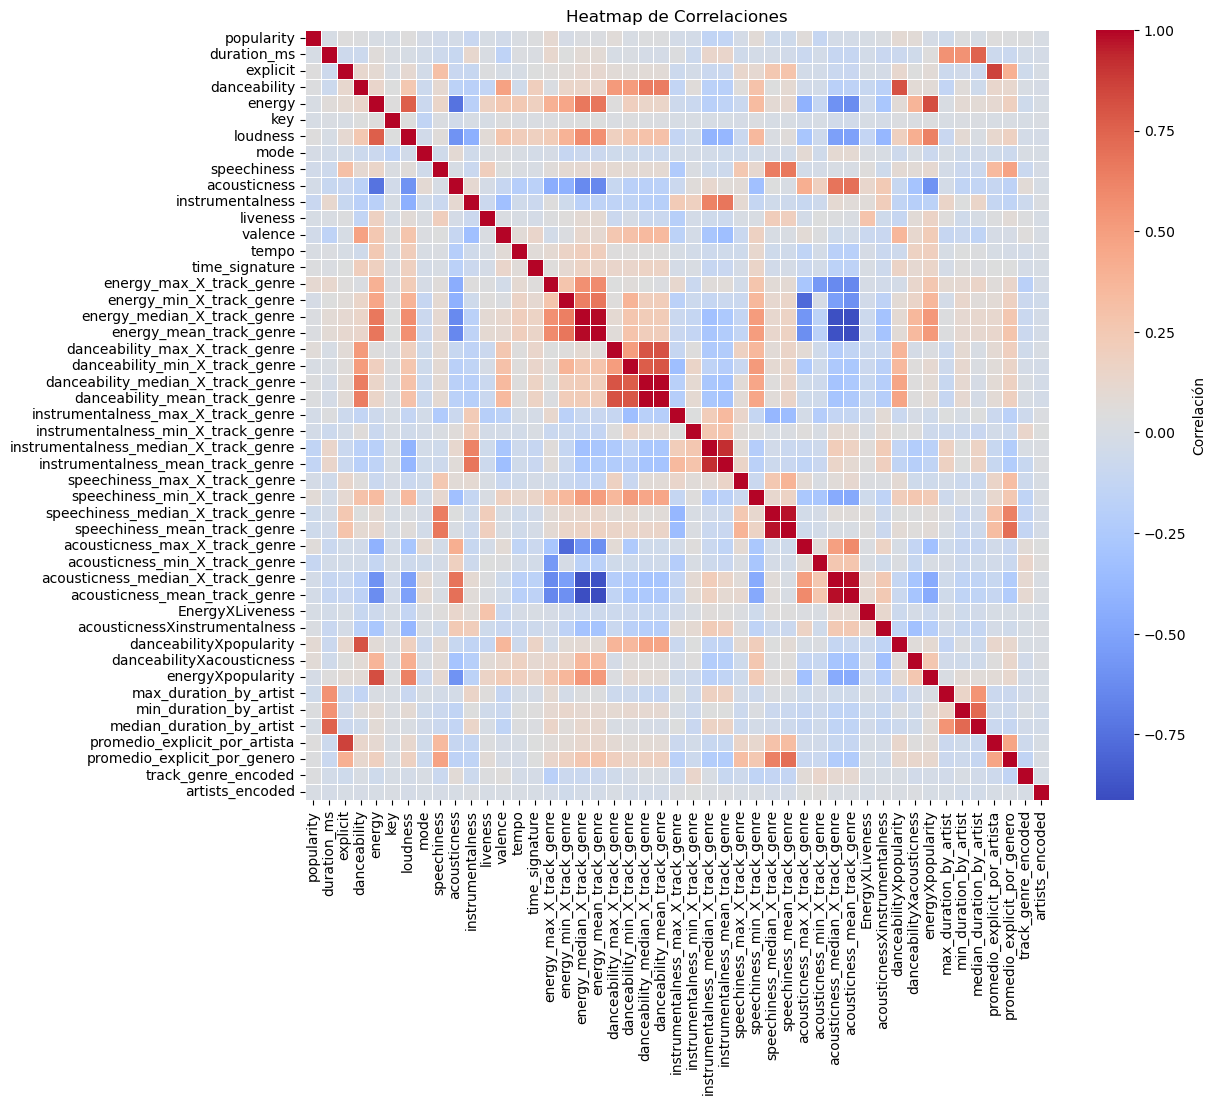

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlación'})
plt.title('Heatmap de Correlaciones')
plt.show()

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X = df.drop('explicit', axis=1)
y = df['explicit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Baseline

In [98]:
baseline_classifier = DummyClassifier(strategy="most_frequent")
baseline_classifier.fit(X_train, y_train)

y_pred_baseline = baseline_classifier.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f'Accuracy del modelo baseline: {accuracy_baseline}')

precision_baseline = precision_score(y_test, y_pred_baseline, zero_division=1)
print(f'Precision del modelo baseline: {precision_baseline}')

roc_auc_baseline = roc_auc_score(y_test, baseline_classifier.predict(X_test))
print(f'AUC-ROC del modelo baseline: {roc_auc_baseline}')

Accuracy del modelo baseline: 0.9156725146198831
Precision del modelo baseline: 1.0
AUC-ROC del modelo baseline: 0.5


# Random Forest

In [86]:
rf_classifier = RandomForestClassifier(random_state=13)
# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10, 20]
# }

# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

best_params = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2000}

best_rf_classifier = RandomForestClassifier(random_state=13, **best_params)
best_rf_classifier.fit(X_train, y_train)

y_pred_rf = best_rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Best Hyperparameters: {best_params}')
print(f'Random Forest Accuracy: {accuracy_rf}')

precision_rf = precision_score(y_test, y_pred_rf)
print(f'Random Forest Precision: {precision_rf}')

roc_auc_rf = roc_auc_score(y_test, best_rf_classifier.predict_proba(X_test)[:, 1])
print(f'Random Forest AUC-ROC: {roc_auc_rf}')

# Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2000}
# Random Forest Accuracy: 0.9792982456140351
# Random Forest Precision: 0.9096385542168675
# Random Forest AUC-ROC: 0.9935229610596401

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2000}
Random Forest Accuracy: 0.9792982456140351
Random Forest Precision: 0.9096385542168675
Random Forest AUC-ROC: 0.9935229610596401


# Gradient Boosting

In [87]:
# gb_classifier = GradientBoostingClassifier(random_state=13)
# param_grid = {
#     'n_estimators': [500,1000,2000],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [5, 10, 20]
# }

# grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_

best_params = {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 2000}
best_gb_classifier = GradientBoostingClassifier(random_state=13, **best_params)
best_gb_classifier.fit(X_train, y_train)
y_pred_gb = best_gb_classifier.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Best Hyperparameters: {best_params}')

print(f'Gradient Boosting Accuracy: {accuracy_gb}')

precision_gb = precision_score(y_test, y_pred_gb)
print(f'Gradient Boosting Precision: {precision_gb}')

roc_auc_gb = roc_auc_score(y_test, best_gb_classifier.predict_proba(X_test)[:, 1])
print(f'Gradient Boosting AUC-ROC: {roc_auc_gb}')

# Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 2000}
# Gradient Boosting Accuracy: 0.9842690058479532
# Gradient Boosting Precision: 0.9315673289183223
# Gradient Boosting AUC-ROC: 0.9968463830464954

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 2000}
Gradient Boosting Accuracy: 0.9842690058479532
Gradient Boosting Precision: 0.9315673289183223
Gradient Boosting AUC-ROC: 0.9968463830464954


# Support Vector Machine (SVM)

In [96]:
svm_linear_classifier = SVC(kernel='linear', random_state=13)
svm_rbf_classifier = SVC(kernel='rbf', random_state=13)
svm_poly_classifier = SVC(kernel='poly', degree=3, random_state=13)

svm_linear_classifier.fit(X_train, y_train)
svm_rbf_classifier.fit(X_train, y_train)
svm_poly_classifier.fit(X_train, y_train)

y_pred_linear = svm_linear_classifier.predict(X_test)
y_pred_rbf = svm_rbf_classifier.predict(X_test)
y_pred_poly = svm_poly_classifier.predict(X_test)

accuracy_linear = accuracy_score(y_test, y_pred_linear)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print(f'SVM Linear Kernel Accuracy: {accuracy_linear}')
print(f'SVM RBF Kernel Accuracy: {accuracy_rbf}')
print(f'SVM Polynomial Kernel Accuracy: {accuracy_poly}')

# SVM Linear Kernel Accuracy: 0.9529239766081872
# SVM RBF Kernel Accuracy: 0.9156725146198831
# SVM Polynomial Kernel Accuracy: 0.9156725146198831

SVM Linear Kernel Accuracy: 0.9529239766081872
SVM RBF Kernel Accuracy: 0.9156725146198831
SVM Polynomial Kernel Accuracy: 0.9156725146198831


In [101]:
precision_linear = precision_score(y_test, y_pred_linear, zero_division=1)
print(f'SVM Linear Kernel Precision: {precision_linear}')

precision_rbf = precision_score(y_test, y_pred_rbf, zero_division=1)
print(f'SVM RBF Kernel Precision: {precision_rbf}')

precision_poly = precision_score(y_test, y_pred_poly, zero_division=1)
print(f'SVM Polynomial Kernel Precision: {precision_poly}')

SVM Linear Kernel Precision: 0.8656716417910447
SVM RBF Kernel Precision: 1.0
SVM Polynomial Kernel Precision: 1.0


In [102]:
roc_auc_linear = roc_auc_score(y_test, y_pred_linear)
print(f'SVM Linear Kernel AUC-ROC: {roc_auc_linear}')

roc_auc_rbf = roc_auc_score(y_test, y_pred_rbf)
print(f'SVM RBF Kernel AUC-ROC: {roc_auc_rbf}')

roc_auc_poly = roc_auc_score(y_test, y_pred_poly)
print(f'SVM Polynomial Kernel AUC-ROC: {roc_auc_poly}')

SVM Linear Kernel AUC-ROC: 0.7577063317170115
SVM RBF Kernel AUC-ROC: 0.5
SVM Polynomial Kernel AUC-ROC: 0.5


# Decision Tree

In [91]:
# param_grid_decision_tree = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search_decision_tree = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid_decision_tree, cv=5)
# grid_search_decision_tree.fit(X_train, y_train)
# best_decision_tree = grid_search_decision_tree.best_estimator_

In [92]:
best_decision_tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

best_decision_tree = DecisionTreeClassifier(random_state=13, **best_decision_tree_params)
best_decision_tree.fit(X_train, y_train)

y_pred_decision_tree = best_decision_tree.predict(X_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(f'Best Decision Tree Parameters: {best_decision_tree_params}')
print(f'Decision Tree Accuracy: {accuracy_decision_tree}')

precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
print(f'Decision Tree Precision: {precision_decision_tree}')

roc_auc_decision_tree = roc_auc_score(y_test, best_decision_tree.predict_proba(X_test)[:, 1])
print(f'Decision Tree AUC-ROC: {roc_auc_decision_tree}')

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.975672514619883
Decision Tree Precision: 0.8552631578947368
Decision Tree AUC-ROC: 0.9377656802148703


# KNN

In [93]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# knn_classifier = KNeighborsClassifier()
# param_grid = {
#     'n_neighbors': list(range(1, 50))
# }

# grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)

# Best Hyperparameters: {'n_neighbors': 5}

In [94]:
best_knn_params = {'n_neighbors': 5}

best_knn_classifier = KNeighborsClassifier(**best_knn_params)
best_knn_classifier.fit(X_train_scaled, y_train)

y_pred_knn = best_knn_classifier.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Best Hyperparameters: {best_knn_params}')
print(f'k-NN Accuracy with Best Hyperparameters: {accuracy_knn}')

precision_knn = precision_score(y_test, y_pred_knn)
print(f'k-NN Precision with Best Hyperparameters: {precision_knn}')

roc_auc_knn = roc_auc_score(y_test, best_knn_classifier.predict_proba(X_test_scaled)[:, 1])
print(f'k-NN AUC-ROC with Best Hyperparameters: {roc_auc_knn}')

Best Hyperparameters: {'n_neighbors': 5}
k-NN Accuracy with Best Hyperparameters: 0.9735087719298245
k-NN Precision with Best Hyperparameters: 0.8978278358809332
k-NN AUC-ROC with Best Hyperparameters: 0.9563458674308984


# XGBoost

In [95]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=13)

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.1],
}

grid_search_xgb = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_params_xgb = grid_search_xgb.best_params_

print(f'Best Hyperparameters: {best_params_xgb}')
best_xgb_classifier = xgb.XGBClassifier(**best_params)
best_xgb_classifier.fit(X_train, y_train)

y_pred_xgb = best_xgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Best Hyperparameters: {best_params}')
print(f'XGBoost Accuracy: {accuracy_xgb}')

precision_xgb = precision_score(y_test, y_pred_xgb)
print(f'XGBoost Precision: {precision_xgb}')

roc_auc_xgb = roc_auc_score(y_test, best_xgb_classifier.predict_proba(X_test)[:, 1])
print(f'XGBoost AUC-ROC: {roc_auc_xgb}')

# Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 2000}
# XGBoost Accuracy: 0.9830994152046784
# XGBoost Precision: 0.9180565627266135
# XGBoost AUC-ROC: 0.9962626062743004

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 2000}


/Users/azulmakk/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 2000}
XGBoost Accuracy: 0.9830994152046784
XGBoost Precision: 0.9180565627266135
XGBoost AUC-ROC: 0.9962626062743004
